In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from baseline_cnn import *
from datetime import datetime
import copy

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        #nn.init.xavier_normal_(m.weight.data)
    #elif classname.find('Linear') != -1:
     #   nn.init.xavier_normal_(m.weight.data)
    
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
def xavier_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)
    
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

net=Nnet().to(computing_device)
net.apply(weights_init)

# Print the model
print(net)

#loss criteria are defined in the torch.nn package
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(net.parameters(),lr = 0.001)

CUDA is supported
Nnet(
  (main): Sequential(
    (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): Conv2d(21, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(20, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(15, 7, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=343, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=201, bias=True)
  )
)


In [22]:
def balance_classes(dataset, num_classes):
    count = [0] * num_classes
    
    for image, label in dataset:
#         label = item
#         print(label)

        # labels are 1-100, indices are 0-199
        # keep track of number of images for each class
        #print(label, end='\r')
        count[label - 1] += 1
        
    balancer = [0.] * num_classes
    total_images = float(len(dataset))

    for i in range(num_classes):
        balancer[i] = total_images / float(count[i])
    
    weights = [0] * len(dataset)
    
    for i, (image, label) in enumerate(dataset):

        weights[i] = balancer[label - 1]
    return weights
    

In [7]:
def choose_images(dataset, indices):
    chosen = [dataset[i] for i in indices]
    return chosen

In [8]:
transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])
dataset = loader('../train.csv','/datasets/cs154-fa19-public/',transform=transform)
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42
    
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

dataset_sizes = {"train": dataset_size * 0.8, "val": split}



In [9]:
train_data = choose_images(dataset, train_indices)

In [24]:
image, label = train_data[0]

In [13]:
#weights = balance_classes(train_data, 200)
#weights = torch.DoubleTensor(weights)

#train_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = {"train": [], "val": []}
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            count = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                print('batch {}'.format(count), end="\r", flush=True)
                count += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            losses[phase].append(epoch_loss)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - epoch_start
        print('Epoch complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses

In [24]:
#Helper function for calculating accuracy
def calculate_accu(outputs, labels, batch_size):
    num_correct = torch.sum(torch.max(outputs, dim = 1)[1] == labels).item()
    return num_correct / batch_size

import copy
# Track the loss across training
total_loss = []
total_accu = []

train_losses = []
train_accuracies = []

avg_minibatch_loss = []
avg_minibatch_accu = []
N = 50

all_models = []

valid_losses = []
valid_accuracies = []


early_stop_counter = 0  # track number of epochs where val loss increases
for epoch in range(50):
    epoch_start_time = datetime.now()
    N_minibatch_loss = 0.0
    N_minibatch_accu = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        print("mini_batch", minibatch_count)
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)
        
        loss = criterion(outputs, labels)
        accu = calculate_accu(outputs, labels, batch_size)
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()    
        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        total_accu.append(accu)
        
        N_minibatch_loss += loss.item()
        N_minibatch_accu += accu
        
        if minibatch_count % N == 49:
            #Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            N_minibatch_accu /= N
            
            print('Epoch %d, average minibatch %d loss: %.3f' % (epoch + 1, minibatch_count+1, N_minibatch_loss))
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            avg_minibatch_accu.append(N_minibatch_accu)
            
            N_minibatch_loss = 0.0
            N_minibatch_accu = 0.0
    
    train_losses.append(np.average(total_loss))
    train_accuracies.append(np.average(total_accu))
    
    # TODO: Implement validation 
    with torch.no_grad():
        
        valid_loss = 0
        valid_accu = 0
        
        for minibatch_count, (images, labels) in enumerate(validation_loader, 0):
            
            #Apply current model to the data
            images, labels = images.to(computing_device), labels.to(computing_device)
            outputs = net(images)
            
            valid_accu += calculate_accu(outputs, labels, batch_size)
            valid_loss += criterion(outputs, labels).item()
        
        avg_valid_accu = valid_accu/minibatch_count
        avg_valid_loss = valid_loss/minibatch_count
        
        print("Valid loss for validation set is ", avg_valid_loss, "%.")
        print("Accuracy for validation set is", avg_valid_accu * 100, "%.")
        
        all_models.append(copy.deepcopy(net))
        
        if not valid_losses:
            model = copy.deepcopy(net)
        elif avg_valid_loss > valid_losses[-1]:
            early_stop_counter += 1
            
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(avg_valid_accu)
            if early_stop_counter == 2:
                print("stopped")
                break
        elif avg_valid_loss < min(valid_losses):
            model = copy.deepcopy(net)
        early_stop_counter = 0
        
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_accu)
    end_time = datetime.now()
    
    epoch_runtime = end_time - epoch_start_time
    print("epoch {} time: {}".format(epoch, epoch_runtime))

In [ ]:
torch.save(net, "trained_model.pt")

# Apply Model On the Test Dataset

In [25]:
model = torch.load("transfer_trained.pt")

In [26]:
#Create test set
test_dataset = loader('../test.csv','/datasets/cs154-fa19-public/',
                      transform = transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size = batch_size)

## Test Set Preformance

In [27]:
#helper functions

#model for performance
def per_class_model_performance(performances):
    
    perf_df = []
    
    #for each class, calculate accuracy, recall, precision and bcr
    for i in range(len(performances)):
        
        cur_perf = performances[i]
        accu, recall, precision, bcr = get_per_class_values(cur_perf)
        
        perf_df.append([accu, precision, recall, bcr])
        
    #make it to a dataframe
    perf_df = pd.DataFrame(perf_df)
    perf_df.columns = ['Accuracy', 'Precision', 'Recall', 'BCR']
    
    return perf_df
 

#get measurement recall, accuracy, precision and bcr value for the current class
def get_per_class_values(cur_perf):    
    
    tp = cur_perf['TP']
    fp = cur_perf['FP']
    tn = cur_perf['TN']
    fn = cur_perf['FN']
    
    #accuracy
    accu = (tp + tn)/(tp + tn + fp + fn)
    
    #recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    #precision
    if fp + tp == 0:
        precision = 0
    else:
        precision = tp / (fp + tp)
        
    #bcr
    bcr = (precision + recall) / 2
    
    return accu, recall, precision, bcr

In [28]:
#Apply to test set and test Performances
all_class_performance = []
test_accuracies = []

#turn list into a sparse matrix
def make_matrix(lst):
    mat = []
    for i in lst:
        cur = [0] * 201
        cur[i] = 1
        mat.append(cur)
    return np.array(mat)


for i in range(201):
    all_class_performance.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

with torch.no_grad(): 
    
    test_accu = 0
    
    for minibatch_count, (images, labels) in enumerate(test_loader, 0):
        
        print("current minibatch: ", minibatch_count, '\r')
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device) 
        outputs = model(images)
        
        test_accu += calculate_accu(outputs, labels, batch_size)
        
        predictions = torch.max(outputs, dim = 1)[1]

        pred = make_matrix(predictions.tolist())
        lab = make_matrix(labels.tolist())

        for i in range(pred.shape[0]):
            for j in range(201):
                if (pred[i][j] == 1) and (lab[i][j] == 1):
                    all_class_performance[j]['TP'] += 1
                elif (pred[i][j] == 1) and (lab[i][j] == 0):
                    all_class_performance[j]['FP'] += 1
                elif (pred[i][j] == 0) and (lab[i][j] == 0):
                    all_class_performance[j]['TN'] += 1
                else:
                    all_class_performance[j]['FN'] += 1
                    
    test_accuracies = (test_accu/minibatch_count)

current minibatch:  0 
current minibatch:  1 
current minibatch:  2 
current minibatch:  3 
current minibatch:  4 
current minibatch:  5 
current minibatch:  6 
current minibatch:  7 
current minibatch:  8 
current minibatch:  9 
current minibatch:  10 
current minibatch:  11 
current minibatch:  12 
current minibatch:  13 
current minibatch:  14 
current minibatch:  15 
current minibatch:  16 
current minibatch:  17 
current minibatch:  18 
current minibatch:  19 
current minibatch:  20 
current minibatch:  21 
current minibatch:  22 
current minibatch:  23 
current minibatch:  24 
current minibatch:  25 
current minibatch:  26 
current minibatch:  27 
current minibatch:  28 
current minibatch:  29 
current minibatch:  30 
current minibatch:  31 
current minibatch:  32 
current minibatch:  33 
current minibatch:  34 
current minibatch:  35 
current minibatch:  36 
current minibatch:  37 
current minibatch:  38 
current minibatch:  39 
current minibatch:  40 
current minibatch:  41 
cu

In [30]:
metrics_df = per_class_model_performance(all_class_performance)
metrics_df.head()

,Accuracy,Precision,Recall,BCR
0,1.000000,0.000000,0.000000,0.000000
1,0.982386,0.280702,0.500000,0.390351
2,0.996601,0.428571,0.666667,0.547619
3,0.995983,0.538462,0.500000,0.519231
4,0.992892,0.346154,0.600000,0.473077


In [31]:
metrics_df.mean()

Accuracy     0.994465
Precision    0.367472
Recall       0.404803
BCR          0.386138
dtype: float64

## Visualizations

In [29]:
import matplotlib.pyplot as plt

### Training and Validation Loss Curves

NameError: name 'train_losses' is not defined

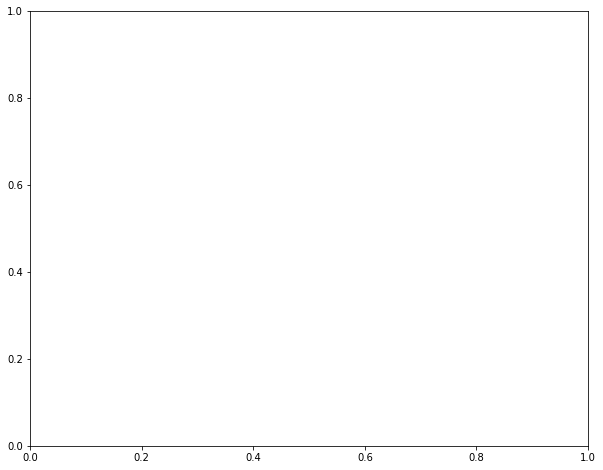

In [30]:
graph_title = 'Training vs Validation Losses for Baseline CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Losses')
ax.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('graphs/baseline_train_vad_loss.png')

### Plot on Training and Testing Accuracy Curves

In [ ]:
graph_title = 'Training vs Validation Accuracies for for Baseline CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_accuracies) + 1), np.array(train_accuracies) * 100, label='Training Accuracies(%)')
ax.plot(np.arange(1, len(valid_accuracies) + 1), np.array(valid_accuracies) * 100, label='Validation Accuracies(%)')
ax.set(xlabel='Number of Epochs', ylabel='Accuracy(%)',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('graphs/baseline_train_test_accu.png')

In [ ]:
print('The test accuracy is ' + str(test_accu/minibatch_count))

### Filter Maps

# Transfer Learning

In [10]:
from torchvision import models
from torch.optim import lr_scheduler
import time
import torch.nn.functional as F

In [15]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 201)
# nn.Sequential(
#     nn.Linear(num_ftrs, 420),
#     nn.ReLU(inplace=True),
#     nn.Linear(420, 201),
# )

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


dataloaders = {'train': train_loader, 'val': validation_loader}
model_conv, losses = train_model(model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 5.0006 Acc: 0.0510
val Loss: 4.6380 Acc: 0.1139
Epoch complete in 2m 27s

Epoch 1/14
----------
train Loss: 4.3781 Acc: 0.1740
val Loss: 4.1369 Acc: 0.2221
Epoch complete in 2m 23s

Epoch 2/14
----------


KeyboardInterrupt: 

In [17]:
torch.save(model_conv, "transfer_trained.pt")

NameError: name 'model_conv' is not defined

### Test for transfer learning

In [18]:
model_conv = torch.load("transfer_trained_balanced.pt")

In [22]:
test_dataset = loader('../test.csv','/datasets/cs154-fa19-public/',
                      transform = transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size = batch_size)

In [23]:
#Apply to test set and test Performances
all_class_performance = []
test_accuracies = []

#turn list into a sparse matrix
def make_matrix(lst):
    mat = []
    for i in lst:
        cur = [0] * 201
        cur[i] = 1
        mat.append(cur)
    return np.array(mat)


for i in range(201):
    all_class_performance.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

with torch.no_grad(): 
    
    test_accu = 0
    
    for minibatch_count, (images, labels) in enumerate(test_loader, 0):
        
        print("current minibatch: ", minibatch_count, end='\r')
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device) 
        outputs = model_conv(images)
        
        test_accu += calculate_accu(outputs, labels, batch_size)
        
        predictions = torch.max(outputs, dim = 1)[1]

        pred = make_matrix(predictions.tolist())
        lab = make_matrix(labels.tolist())

        for i in range(pred.shape[0]):
            for j in range(201):
                if (pred[i][j] == 1) and (lab[i][j] == 1):
                    all_class_performance[j]['TP'] += 1
                elif (pred[i][j] == 1) and (lab[i][j] == 0):
                    all_class_performance[j]['FP'] += 1
                elif (pred[i][j] == 0) and (lab[i][j] == 0):
                    all_class_performance[j]['TN'] += 1
                else:
                    all_class_performance[j]['FN'] += 1
                    
    test_accuracies = (test_accu/minibatch_count)
print(test_accuracies)

NameError: name 'calculate_accu' is not defined

In [ ]:
metrics_df = per_class_model_performance(all_class_performance)
metrics_df.describe

In [89]:
def get_values(df):
    sorted_accs = df.sort_values(by="Accuracy", ascending=False)
    top_5 = sorted_accs[1:6]
    bot_5 = sorted_accs[-5:]
    return top_5, bot_5
    

In [83]:
top, bottom = get_values(metrics_df)
print(top)
print(bottom)

     Accuracy  Precision    Recall       BCR
134  0.999691   0.933333  1.000000  0.966667
14   0.999073   1.000000  0.500000  0.750000
156  0.998455   1.000000  0.166667  0.583333
56   0.998455   0.833333  0.555556  0.694444
49   0.998455   0.857143  0.600000  0.728571
     Accuracy  Precision    Recall       BCR
22   0.983004   0.290909  0.500000  0.395455
93   0.982695   0.245283  0.448276  0.346779
1    0.982386   0.280702  0.500000  0.390351
109  0.982386   0.245283  0.433333  0.339308
37   0.977750   0.243902  0.666667  0.455285


In [40]:
import matplotlib.pyplot as plt

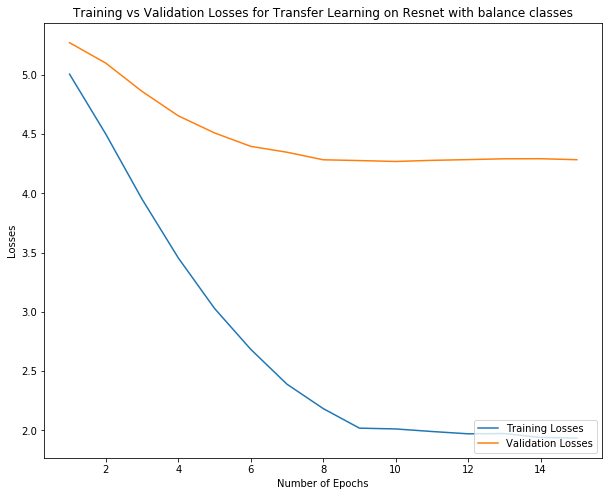

In [60]:
graph_title = 'Training vs Validation Losses for Transfer Learning on Resnet with balance classes'
train_losses = losses["train"]
valid_losses = losses['val']

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Losses')
ax.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('graphs/baseline_train_vad_loss_balanced.png')

In [49]:
for idx, m in enumerate(model.modules()):
    print(idx)
    print(m)

0
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): 

In [52]:
filter_imgs = []
model = model_conv
# Get the weights for each needed filter
for idx, m in enumerate(model.modules()):
    if idx == 16:     
        #early filters
        early = (m.weight.cpu().data.numpy()[1])[0]  
        early2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(early)
        filter_imgs.append(early2)

    if idx == 36:
        # middle filters
        middle = (m.weight.cpu().data.numpy()[1])[0]
        middle2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(middle)
        filter_imgs.append(middle2)
    
    if idx == 61:
        # late filters
        late = (m.weight.cpu().data.numpy()[1])[0]
        late2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(late)
        filter_imgs.append(late2)
        break


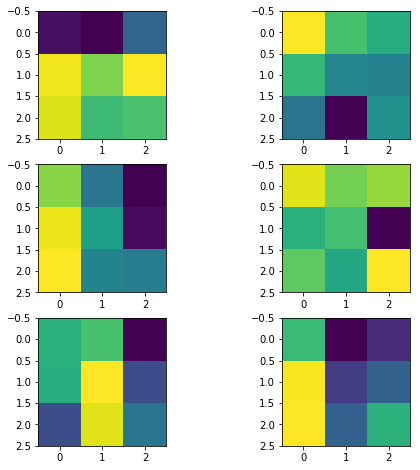

In [54]:
fig = plt.figure(figsize=(8, 8))
cols = 2
rows = 3

for i in range(1, cols * rows + 1):
    img = filter_imgs[i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    
plt.savefig('transfer_filter.png')